# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


### Загрузка данных, общая информация

In [1]:
# Подключение библиотек

import numpy as np
import pandas as pd
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Общая информация о датасете

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# Проверка наличия явных дубликатов

df.duplicated().sum()

0

#### Вывод:
Количество строк и столбцов таблицы: 16715 и 11, соответственно. Предварительно можно считать, что этих данных достаточно для исследования.

Названия столбцов не соответствуют "хорошему стилю", имеет смысл привести их к нижнему регистру. 

Пропуски в данных есть, в шести столбцах. Явных дубликатов не обнаружено. Имеет смысл подумать о более "прозрачной" категоризации данных в признаке `Rating`.

Также есть несоответствия в типах данных: 
- столбец `Year_of_Release` имеет тип `float`, однако, по смыслу данных предпочтительнее целочисленный тип; 
- столбец `User_Score` имеет тип `object`, логичнее было бы привести данные в столбце к типу `float`.   


### Предобработка данных

Приведём наименования столбцов к нижнему регистру:

In [6]:
df.columns = df.columns.str.lower()

In [7]:
# Проверка

print(f'Количество столбцов датафрейма равно: {df.shape[1]}')
df.head() 

Количество столбцов датафрейма равно: 11


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Обработка пропусков, аномалий и неявных дубликатов. Приведение типов данных. 

In [8]:
# Количество пропущенных значений для каждого столбца

df.isna().sum().sort_values()

platform              0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
name                  2
genre                 2
year_of_release     269
user_score         6701
rating             6766
critic_score       8578
dtype: int64

* #### Признаки `name` и `genre`

In [9]:
df.loc[(df['name'].isna()) & (df['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В данных столбцах наблюдается всего два пропуска, очень мало, по сравнению с общим объёмом данных. Также, продажи игр (без имени и жанра) весьма скромные. Удалим эти записи:

In [10]:
df.dropna(subset=['name', 'genre'], inplace=True)
df.reset_index(drop=True, inplace=True) # cброс индексов, с удалением старых индексов

print(f'Количество строк датафрейма равно: {df.shape[0]}')

Количество строк датафрейма равно: 16713


In [11]:
# Проверка

df[['name', 'genre']].isna().sum()

name     0
genre    0
dtype: int64

Посмотрим на уникальные значения в столбцах. Проверим на наличие неявных дубликатов:

In [12]:
df['name'].value_counts()

Need for Speed: Most Wanted                         12
Ratatouille                                          9
LEGO Marvel Super Heroes                             9
FIFA 14                                              9
Madden NFL 07                                        9
                                                    ..
Jewels of the Tropical Lost Island                   1
Sherlock Holmes and the Mystery of Osborne House     1
The King of Fighters '95 (CD)                        1
Megamind: Mega Team Unite                            1
Haitaka no Psychedelica                              1
Name: name, Length: 11559, dtype: int64

In [13]:
# Значений очень много, выявить дубликаты затруднительно. 
# Видно, что в некоторых названиях есть посторонние символы и лишние пробелы. Оставим без изменений.

df['name'].sort_values().unique()

array([' Beyblade Burst', ' Fire Emblem Fates', " Frozen: Olaf's Quest",
       ..., 'uDraw Studio: Instant Artist', 'wwe Smackdown vs. Raw 2006',
       '¡Shin Chan Flipa en colores!'], dtype=object)

In [14]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

* #### Признак `platform` 

Посмотрим на уникальные значения в столбцах. Проверив на наличие неявных дубликатов делаем вывод, что они отсутствуют:

In [15]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [16]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

* #### Признак `year_of_release` 

In [17]:
# Количество пропусков в столбце

df['year_of_release'].isna().sum()

269

In [18]:
df['year_of_release'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.,   nan])

Сгруппируем данные по признаку `name`. Посмотрим, быть может игры с одинаковыми названиями выходили в один и тот же год:

In [19]:
df_range_of_years = df.groupby('name')['year_of_release'].agg(['count', 'min', 'max'])
df_range_of_years['range'] = df_range_of_years['max'] - df_range_of_years['min']
df_range_of_years.sort_values(by='range', ascending=False).head()

,count,min,max,range
name,,,,
Battlezone,3,1982.0,2016.0,34.0
Romance of the Three Kingdoms II,2,1991.0,2015.0,24.0
Bomberman,4,1985.0,2008.0,23.0
Final Fantasy III,4,1990.0,2012.0,22.0
Lode Runner,2,1984.0,2006.0,22.0


Так как разница между годами выпуска игр с одинаковыми названиями достаточно существенная, придумать логичную замену пропусков в признаке `year_of_release` не представляеся возможным. Самих пропусков мало (269 значений против 16713 записей), удалим их. Также изменим тип данных в столбце на `int`:

In [20]:
df.dropna(subset=['year_of_release'], inplace=True)
df.reset_index(drop=True, inplace=True) # cброс индексов, с удалением старых индексов

print(f'Количество строк датафрейма равно: {df.shape[0]}')

Количество строк датафрейма равно: 16444


In [21]:
# Проверка

df['year_of_release'].isna().sum()

0

In [22]:
df['year_of_release'] = df['year_of_release'].astype(int)

In [23]:
# Проверка

df['year_of_release'].dtype

dtype('int32')

* #### Признаки `user_score` и `critic_score`

In [24]:
# Количество пропущенных значений в столбцах

df[['user_score', 'critic_score']].isna().sum().sort_values()

user_score      6605
critic_score    8461
dtype: int64

In [25]:
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В признаке `user_score`, помимо пропусков, встречается значение `tbd` (TBD — аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков). Заменим их на `NaN`, изменим тип данных в столбце `user_score` на `float`.

In [26]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

In [27]:
df['user_score'] = df['user_score'].astype(float)

In [28]:
df[['user_score', 'critic_score']].isna().sum().sort_values()

critic_score    8461
user_score      8981
dtype: int64

Рассмотрим взаимосвязь оценок критиков и пользователей. Для этого возьмём срез данных (выберем только те строки, в которых, в указанных признаках, отсутствуют пропуски): 

In [29]:
df_score = df.loc[(df['user_score'].notna()) & (df['critic_score'].notna()), ['user_score', 'critic_score']]
df_score.isna().sum()

user_score      0
critic_score    0
dtype: int64

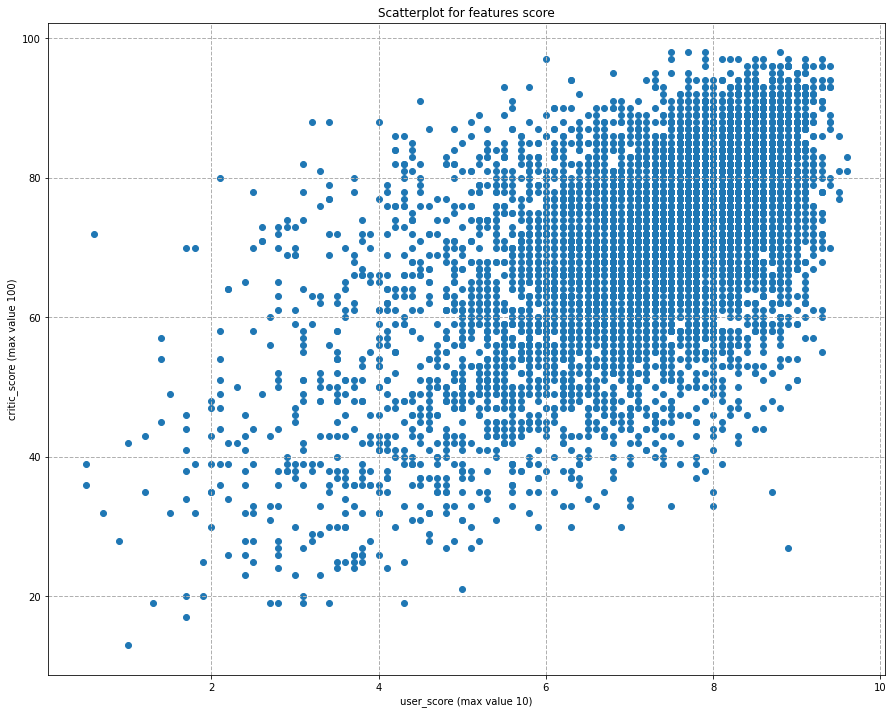

In [30]:
# Строим диаграмму рассеяния для признаков оценки

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12) 

ax.scatter(x=df['user_score'], y=df['critic_score'])
ax.grid(linewidth = 1,   
        linestyle = '--')

# добавляем название графика
ax.set(title='Scatterplot for features score')

# добавляем подписи к осям:
ax.set_xlabel('user_score (max value 10)')
ax.set_ylabel('critic_score (max value 100)')

plt.show()

In [31]:
# Коэффициент корреляции Пирсона

df_score['user_score'].corr(df['critic_score']).round(2)

0.58

Корреляция между признаками средняя. Будь связь сильнее, то можно было бы заполнить пропуски, исходя из предположения о "приблизительно" линейной зависимости между данными двух столбцов (для тех строк, в которых ровно один из признаков не имеет пропуска). В данном случае эта идея кажется нецелесообразной.

Посмотрим на описательные статистики данных признаков, сгруппировав предварительно данные по жанрам. Возможно, часть пропусков имеет смысл заменить на медианы?

In [32]:
df_score_by_genre = df.groupby('genre')[['user_score', 'critic_score']].agg(['count', 'min', 'max', 'mean', 'median'])
df_score_by_genre

user_score                            critic_score              \
                  count  min  max      mean median        count   min   max   
genre                                                                         
Action             1796  0.3  9.5  7.058129    7.4         1851  19.0  98.0   
Adventure           298  0.0  9.4  7.139597    7.6          320  17.0  93.0   
Fighting            395  0.9  9.2  7.295949    7.6          405  23.0  98.0   
Misc                429  0.5  9.2  6.805828    7.1          509  19.0  93.0   
Platform            424  0.2  9.4  7.305896    7.7          490  19.0  97.0   
Puzzle              125  1.1  9.3  7.138400    7.5          220  25.0  90.0   
Racing              629  0.3  9.5  7.040859    7.4          725  13.0  96.0   
Role-Playing        737  1.4  9.7  7.624423    7.8          731  35.0  96.0   
Shooter             905  1.2  9.3  7.053260    7.4          923  27.0  97.0   
Simulation          339  2.1  9.6  7.132153    7.5          348  31.0  92.0   
Sports             1081  0.2  9.5  6.951434    7.4         1165  19.0  98.0   
Strategy            305  0.6  9.4  7.294426    7.8          296  35.0  94.0   

                                
                   mean median  
genre                           
Action        66.676931   68.0  
Adventure     65.268750   66.0  
Fighting      69.155556   72.0  
Misc          66.648330   69.0  
Platform      68.124490   69.5  
Puzzle        67.231818   70.0  
Racing        68.006897   69.0  
Role-Playing  72.655267   74.0  
Shooter       70.260022   73.0  
Simulation    68.609195   70.0  
Sports        71.993133   75.0  
Strategy      72.158784   73.0

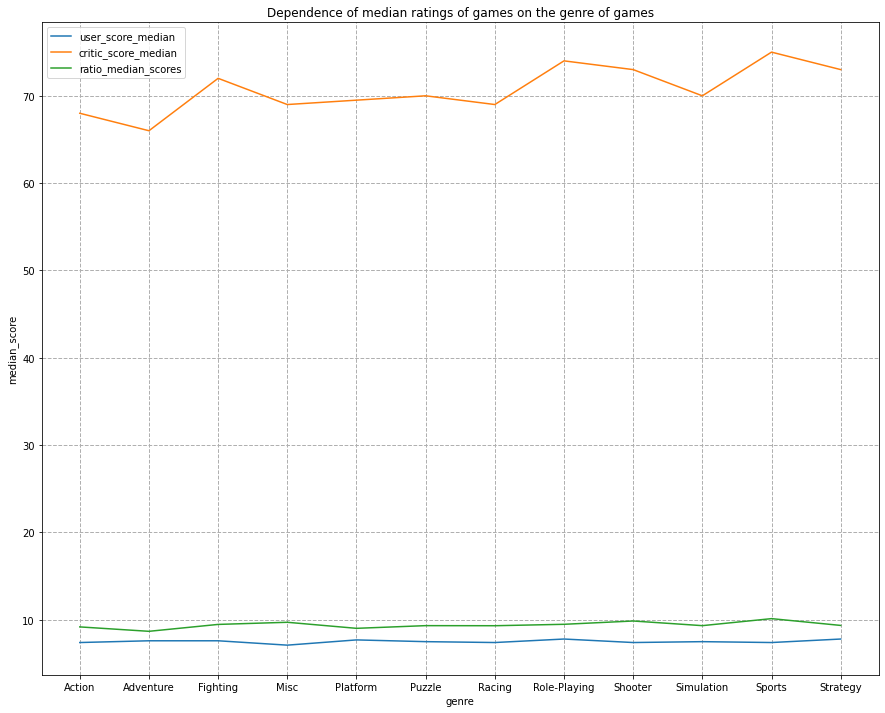

In [33]:
# Строим линейные графики зависимости медиан оценок игр от жанра игр

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12)

X1 = df_score_by_genre.index
Y1 = df_score_by_genre['user_score']['median']
Y2 = df_score_by_genre['critic_score']['median']
Y3 = Y2 / Y1 # во сколько раз, в среднем, оценка критиков отличается от оценки пользователей

ax.plot(X1, Y1, label='user_score_median')
ax.plot(X1, Y2, label='critic_score_median')
ax.plot(X1, Y3, label='ratio_median_scores')

ax.legend()
ax.grid(linewidth = 1,   
        linestyle = '--')

# добавляем название графика
ax.set(title='Dependence of median ratings of games on the genre of games')

# добавляем подписи к осям:
ax.set_xlabel('genre')
ax.set_ylabel('median_score')

plt.show()

Медианные значения оценок критиков отличаются от соответствующих значений оценок пользователей приблизительно с одним и тем же коэффициентом пропорциональности (колебания в пределах 7.5 - 10.1), заменим пропуски на медианы групп (по жанрам), но только в тех случаях, когда один из признаков пропуска не имеет:

In [34]:
condition = (df['user_score'].notna()) & (df['critic_score'].isna())

In [35]:
df.loc[condition, 'critic_score'] = df.groupby('genre')['critic_score'].apply(lambda x: x.fillna(x.median()))

In [36]:
df.loc[condition, ['user_score', 'critic_score']].count()

user_score      569
critic_score    569
dtype: int64

In [37]:
condition = (df['user_score'].isna()) & (df['critic_score'].notna())

In [38]:
df.loc[condition, 'user_score'] = df.groupby('genre')['user_score'].apply(lambda x: x.fillna(x.median()))

In [39]:
df.loc[condition, ['user_score', 'critic_score']].count()

user_score      1089
critic_score    1089
dtype: int64

In [40]:
df[['user_score', 'critic_score']].isna().sum().sort_values()

user_score      7892
critic_score    7892
dtype: int64

Оставшиеся пропуски не обрабатываем, так как их количество слишком существенно, около 50%, и замена на какие-либо статистики может привести к искажению данных.

* #### Признак `rating`

In [41]:
# Посмотрим на уникальные значения рейтинга

df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

Присутствуют неявные дубликаты, так как рейтинг `E`, согласно информации из Википедии, изначально обозначался как `K-A`. Заменим старое обозначение на актуальное:

In [42]:
df.loc[df['rating'] == 'K-A', 'rating'] = 'E'

In [43]:
# Проверка

df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'M', 'RP', 'T', nan], dtype=object)

In [44]:
# Количество пропусков в столбце

df['rating'].isna().sum()

6676

Посмотрим на то, какой процент игр каждого рейтинга занимает от игр определенного жанра. Сгруппируем данные по жанру и рейтингу, и подсчитаем количество игр:

In [45]:
df_genre_rating = df.groupby(['genre', 'rating']).agg({'rating': 'count'})
df_genre_rating = df_genre_rating.rename(columns={'rating': 'number_of_games'})
df_genre_rating.reset_index(inplace=True)
df_genre_rating.head(15)

,genre,rating,number_of_games
0,Action,AO,1
1,Action,E,410
2,Action,E10+,468
3,Action,EC,1
4,Action,M,596
5,Action,T,670
6,Adventure,E,159
7,Adventure,E10+,67
8,Adventure,EC,2
9,Adventure,M,98


Подсчитаем общее количество игр по каждой группе (по жанрам):

In [46]:
df_total_genre = pd.DataFrame(df.groupby('genre')['name'].agg('count'), columns=['name'])
df_total_genre = df_total_genre.rename(columns={'name': 'total_number_of_games'})
df_total_genre.reset_index(inplace=True)
df_total_genre

,genre,total_number_of_games
0,Action,3307
1,Adventure,1293
2,Fighting,837
3,Misc,1721
4,Platform,878
5,Puzzle,569
6,Racing,1226
7,Role-Playing,1481
8,Shooter,1296
9,Simulation,857


Найдем, какой процент игры определенного рейтинга занимают от всех игр определенного жанра (с учётом пропусков в данных):

In [47]:
df_percent_rating_from_genre = df_genre_rating.merge(df_total_genre)
df_percent_rating_from_genre['percent'] = ((df_percent_rating_from_genre['number_of_games'] / 
                                            df_percent_rating_from_genre['total_number_of_games']) * 100).round(2)

df_percent_rating_from_genre.sort_values(by='percent', ascending=False).head(10)

,genre,rating,number_of_games,total_number_of_games,percent
43,Sports,E,1162,2306,50.39
24,Puzzle,E,284,569,49.91
27,Racing,E,576,1226,46.98
37,Shooter,M,553,1296,42.67
14,Fighting,T,357,837,42.65
20,Platform,E,354,878,40.32
39,Simulation,E,321,857,37.46
34,Role-Playing,T,415,1481,28.02
38,Shooter,T,340,1296,26.23
15,Misc,E,450,1721,26.15


Для жанров `Puzzle` и `Sports` заменим пропуски в признаке рейтинга на `E`, остальные пропуски оставим:

In [48]:
df.loc[(df['genre'] == 'Puzzle') & (df['rating'].isna()), 'rating'] = 'E'
df.loc[(df['genre'] == 'Sports') & (df['rating'].isna()), 'rating'] = 'E'

In [49]:
# Смотрим на количество оставшихся пропусков

df['rating'].isna().sum()

5615

Для возможности дальнейшего анализа влияния рейтинга ESRB на продажи заполним оставшиеся пропуски в признаке `rating` на значение `unknown`:

In [50]:
df['rating'] = df['rating'].fillna('unknown')

In [51]:
# Проверка

df['rating'].isna().sum()

0

Посчитаем суммарные продажи во всех регионах, запишем их в отдельный столбец и изменим порядок следования столбцов согласно логике данных:

In [52]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [53]:
df = df[['name', 'platform', 'genre', 'year_of_release', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales', 
         'critic_score', 'user_score', 'rating']]
df.head() 

,name,platform,genre,year_of_release,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Wii Sports,Wii,Sports,2006,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,Platform,1985,29.08,3.58,6.81,0.77,40.24,NaN,NaN,unknown
2,Mario Kart Wii,Wii,Racing,2008,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,Sports,2009,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,Role-Playing,1996,11.27,8.89,10.22,1.00,31.38,NaN,NaN,unknown


#### Вывод:
Проведён первичный анализ данных. Названия столбцов приведены к единому, "хорошему", стилю. Там, где это было возможно, устранены пропуски, обработаны дубликаты, изменены типы данных:

- В признаках `name`, `genre` и `year_of_release` удалены пропуски; тип данных столбца `year_of_release` изменён на `int`;

- Рассмотрены признаки `user_score` и `critic_score`. Пропуски в данных признаках частично заменены на медианные значения. В столбце `user_score` обработаны значения `tbd`, тип данных изменён на `float`;

- В признаке `rating` обработаны неявные дубликаты и заполнена часть пропусков. Пропуски, для которых не удалось подобрать логичную замену, заполнены значением `unknown` (заглушка);

- Посчитан и добавлен новый признак `total_sales` (суммарные продажи во всех регионах).

### Исследовательский анализ данных

* Посмотрим, сколько игр выпускалось в разные годы. Ответим на вопрос "Важны ли данные за все периоды?".

In [54]:
# Посчитаем число вышедших игр и проданных копий в зависимости от года выпуск

df_number_released = df.groupby('year_of_release')[['total_sales']].sum().join(
    df.groupby('year_of_release')[['name']].count()
)

df_number_released.columns = ['total_sales', 'number_of_games']

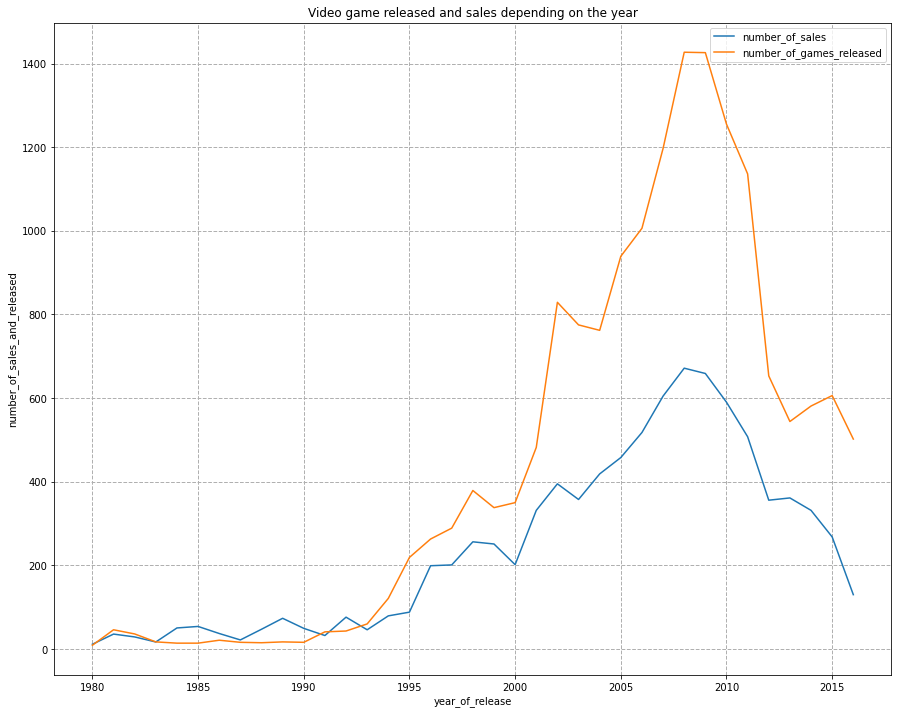

In [55]:
# Строим график зависимости числа и продаж вышедших игр от года выпуска

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12)

ax.plot(df_number_released.index, df_number_released['total_sales'], label='number_of_sales')
ax.plot(df_number_released.index, df_number_released['number_of_games'], label='number_of_games_released')

ax.legend()
ax.grid(linewidth=1,   
        linestyle='--')

# добавляем название графика
ax.set(title='Video game released and sales depending on the year')

# добавляем подписи к осям:
ax.set_xlabel('year_of_release')
ax.set_ylabel('number_of_sales_and_released')

plt.show()

С начала рассматриваемого периода наблюдается рост как количества вышедших игр, так и их продаж (незначительный, с последующим увеличением темпа). Пики продаж и выпуска игр достигаются приблизительно в 2008 году, после чего, начинается спад по обоим показателям. В период с 2013-2015 г. уровень продаж изменяется более менее "плавно" (количество выпущенных игр также незначительно растёт, без сильных скачков), к 2016 году наблюдается существенное снижение, возможно, обусловленное тем, что данные за этот год неполные.
Целесообразно для дальнейшего прогноза учитывать данные, начиная с 2013 года.

* Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Ответим на вопрос "За какой характерный срок появляются новые и исчезают старые платформы?".

Составим таблицу, рассчитав диапазоны лет, в которые выпускались игры на определенных платформах, а также упорядочим данную таблицу по суммарному объёму продаж, и выделим платформы с наибольшими значениями продаж:

In [56]:
# Функция вычисляет разность между самым поздним годом выпуска игры и самым ранним

def diff_years(year):
    return max(year) - min(year)

In [57]:
(
    df.groupby('platform')[['total_sales', 'year_of_release']]
    .agg({'total_sales': 'sum', 'year_of_release': ['max', 'min', diff_years]})
    .droplevel(0, axis=1)
    .sort_values(by='sum', ascending=False)
    .head(10)
)

,sum,max,min,diff_years
platform,,,,
PS2,1233.56,2011,2000,11
X360,961.24,2016,2005,11
PS3,931.34,2016,2006,10
Wii,891.18,2016,2006,10
DS,802.78,2013,1985,28
PS,727.58,2003,1994,9
PS4,314.14,2016,2013,3
GBA,312.88,2007,2000,7
PSP,289.53,2015,2004,11


In [58]:
# Список платформ с наибольшими суммарными продажами

platforms_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Для построения распределения по годам берём первые шесть платформ из сгруппированных данных:

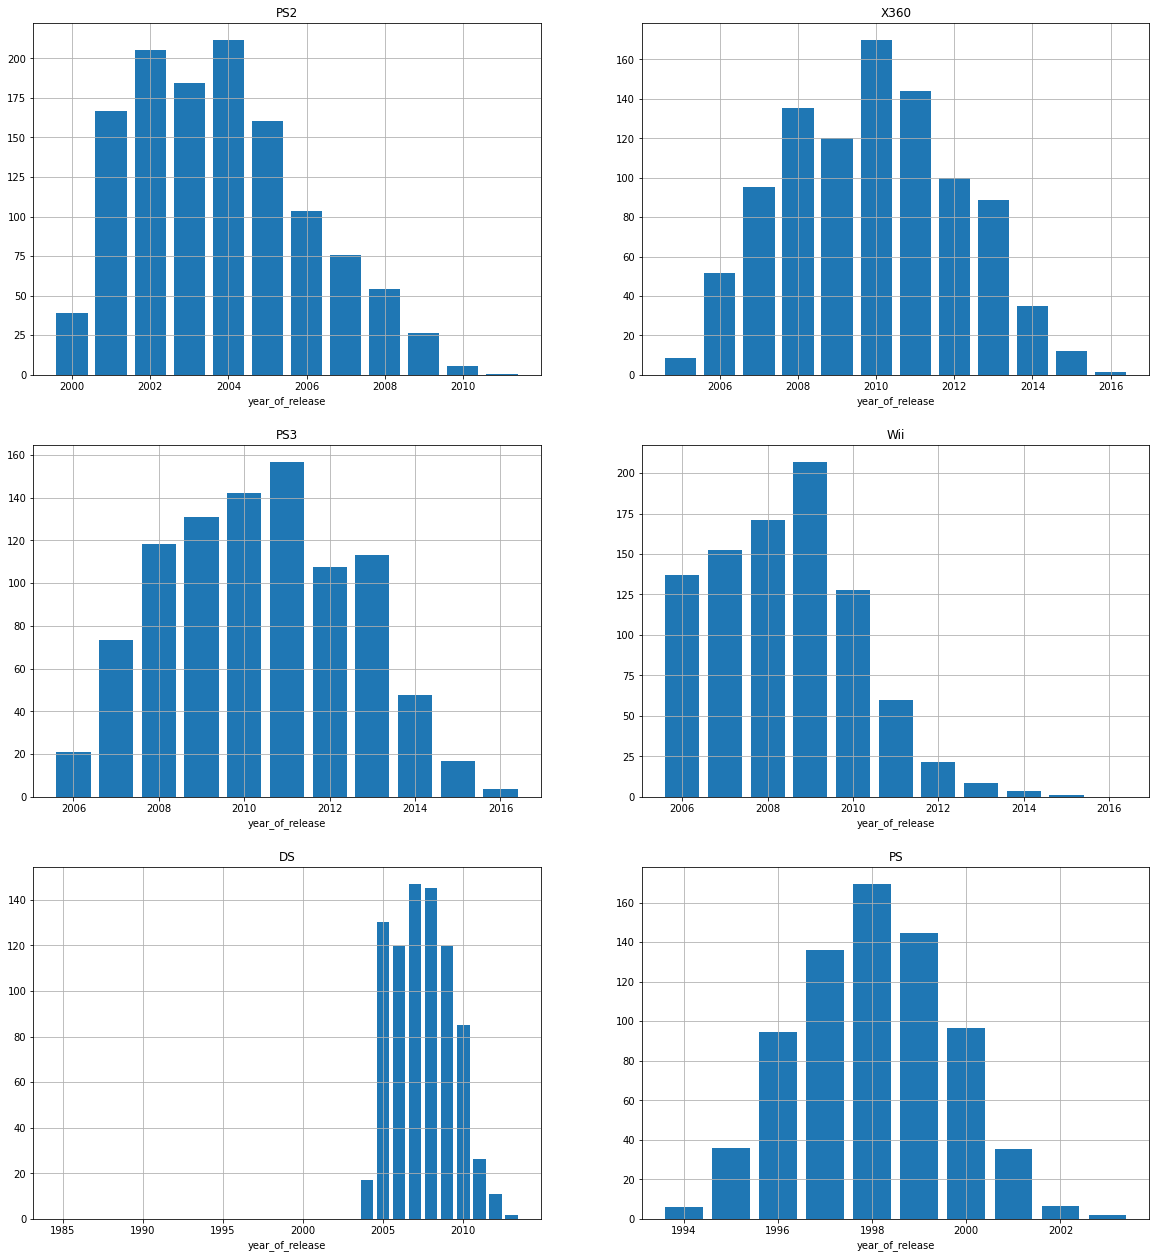

In [59]:
# Строим шесть графиков 

fig, axes = plt.subplots(nrows=3, ncols=2)

# задаём ширину и высоту 
fig.set_figwidth(20)  
fig.set_figheight(22)

axes[0, 0].bar(df[df['platform'] == 'PS2'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'PS2'].groupby('year_of_release')['total_sales'].sum())

axes[0, 1].bar(df[df['platform'] == 'X360'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'X360'].groupby('year_of_release')['total_sales'].sum())

axes[1, 0].bar(df[df['platform'] == 'PS3'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'PS3'].groupby('year_of_release')['total_sales'].sum())

axes[1, 1].bar(df[df['platform'] == 'Wii'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'Wii'].groupby('year_of_release')['total_sales'].sum())

axes[2, 0].bar(df[df['platform'] == 'DS'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'DS'].groupby('year_of_release')['total_sales'].sum())

axes[2, 1].bar(df[df['platform'] == 'PS'].groupby('year_of_release')['total_sales'].sum().index, 
               df[df['platform'] == 'PS'].groupby('year_of_release')['total_sales'].sum())


axes[0, 0].set(title='PS2')
axes[0, 1].set(title='X360')
axes[1, 0].set(title='PS3')
axes[1, 1].set(title='Wii')
axes[2, 0].set(title='DS')
axes[2, 1].set(title='PS')

for ax in axes.flat:
    ax.set(xlabel='year_of_release')
    ax.grid()
    
plt.show()

В основном срок жизни платформ составляет 9-11 лет, встречаются платформы, которые "живут" меньше, но и долгожители тоже есть (например, 28 лет для игр на платформе DS). Пики продаж как правило длятся в течение четырёх-пяти лет.

* Возьмём данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не будем учитывать в работе данные за предыдущие годы.

Далее будем рассматривать данные с учётом актуального периода исследования: за 2013-2016 г. Сделаем выборку из данных, согласно этому условию:

In [60]:
# В качестве актуального периода выбираем 2013-2016 гг.

df = df.query('2013 <= year_of_release <= 2016')
df.reset_index(drop=True, inplace=True)
df.head()

,name,platform,genre,year_of_release,na_sales,eu_sales,jp_sales,other_sales,total_sales,critic_score,user_score,rating
0,Grand Theft Auto V,PS3,Action,2013,7.02,9.09,0.98,3.96,21.05,97.0,8.2,M
1,Grand Theft Auto V,X360,Action,2013,9.66,5.14,0.06,1.41,16.27,97.0,8.1,M
2,Call of Duty: Black Ops 3,PS4,Shooter,2015,6.03,5.86,0.36,2.38,14.63,NaN,NaN,unknown
3,Pokemon X/Pokemon Y,3DS,Role-Playing,2013,5.28,4.19,4.35,0.78,14.60,NaN,NaN,unknown
4,Grand Theft Auto V,PS4,Action,2014,3.96,6.31,0.38,1.97,12.62,97.0,8.3,M


* Какие платформы лидируют по продажам, растут или падают? Рассмотрим несколько потенциально прибыльных платформ.

In [61]:
df.groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False)

,sum
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


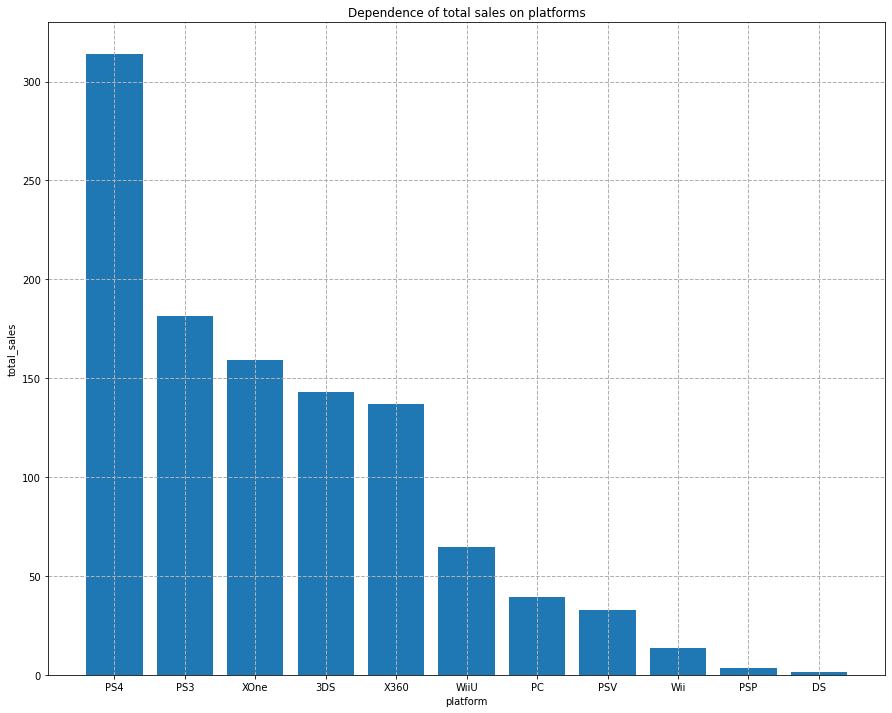

In [62]:
# Строим график зависимости суммарных продаж от платформ

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12)

ax.bar(df.groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False).index, 
       df.groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False)['sum'])

ax.grid(linewidth=1,   
        linestyle='--')

# добавляем название графика
ax.set(title='Dependence of total sales on platforms')

# добавляем подписи к осям:
ax.set_xlabel('platform')
ax.set_ylabel('total_sales')

plt.show()

In [63]:
data = df.pivot_table(index='platform', columns='year_of_release', values='total_sales', aggfunc='sum').fillna(0)
data

year_of_release,2013,2014,2015,2016
platform,,,,
3DS,56.57,43.76,27.78,15.14
DS,1.54,0.00,0.00,0.00
PC,12.38,13.28,8.52,5.25
PS3,113.25,47.76,16.82,3.60
PS4,25.99,100.00,118.90,69.25
PSP,3.14,0.24,0.12,0.00
PSV,10.59,11.90,6.25,4.25
Wii,8.59,3.75,1.14,0.18
WiiU,21.65,22.03,16.35,4.60


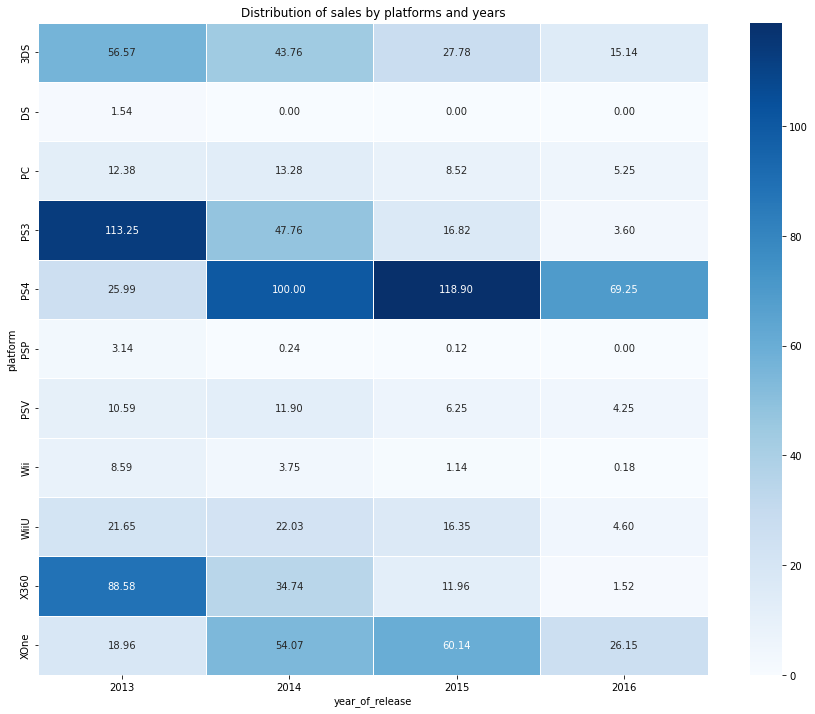

In [64]:
# Строим тепловую карту для оценки продаж в зависимости от платформы и года выпуска

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(15)  
fig.set_figheight(12) 

sns.heatmap(data, ax=ax, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

# добавляем название графика
ax.set(title='Distribution of sales by platforms and years')

plt.show()

Лидеры по продажам игры на платформе PS4, далее идут игры на платформе PS3, и примерно равномерно распределены продажи игр на платформах X360, XOne, 3DS. Однако, только для платформ PS4 и XOne наблюдается рост числа продаж с 2013 года (до 2016г., не включая, тк данные по этому году неполные), тогда как для остальных платформ из перечисленных выше - снижение продаж.

* Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.

In [65]:
# Топ 5 платформ, лидирующих по продажам

platforms_top5 = df.groupby('platform')['total_sales'].agg(['sum']).sort_values(by='sum', ascending=False).head().index

In [66]:
# platforms_top5

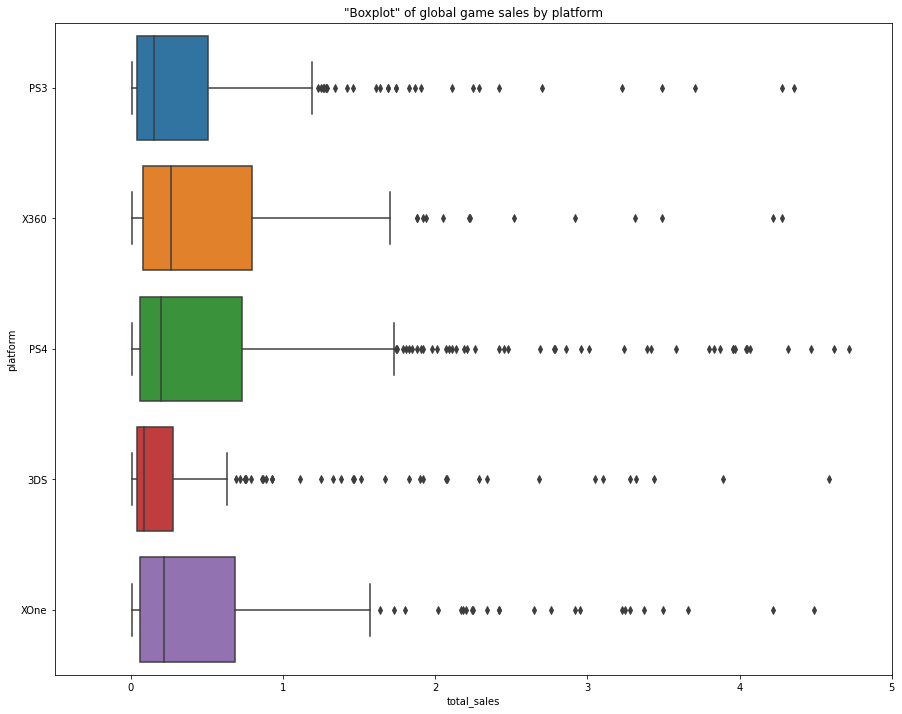

In [67]:
# Строим "ящик с усами" по глобальным продажам игр в разбивке по платформам

fig, ax = plt.subplots()

fig.set_figwidth(15)  
fig.set_figheight(12) 

sns.boxplot(y='platform', x='total_sales', data=df[df['platform'].isin(platforms_top5)], ax=ax, orient="h")

ax.set(title='"Boxplot" of global game sales by platform')

plt.xlim(-0.5, 5)
plt.show()

Наблюдаем нарушение симметрии (скос вправо), плюс, довольно большое количество выбросов. Следовательно, популярные платформы выдают продажи выше средних.

* Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сделаем выводы.
* Сопоставим выводы с продажами игр на других платформах.

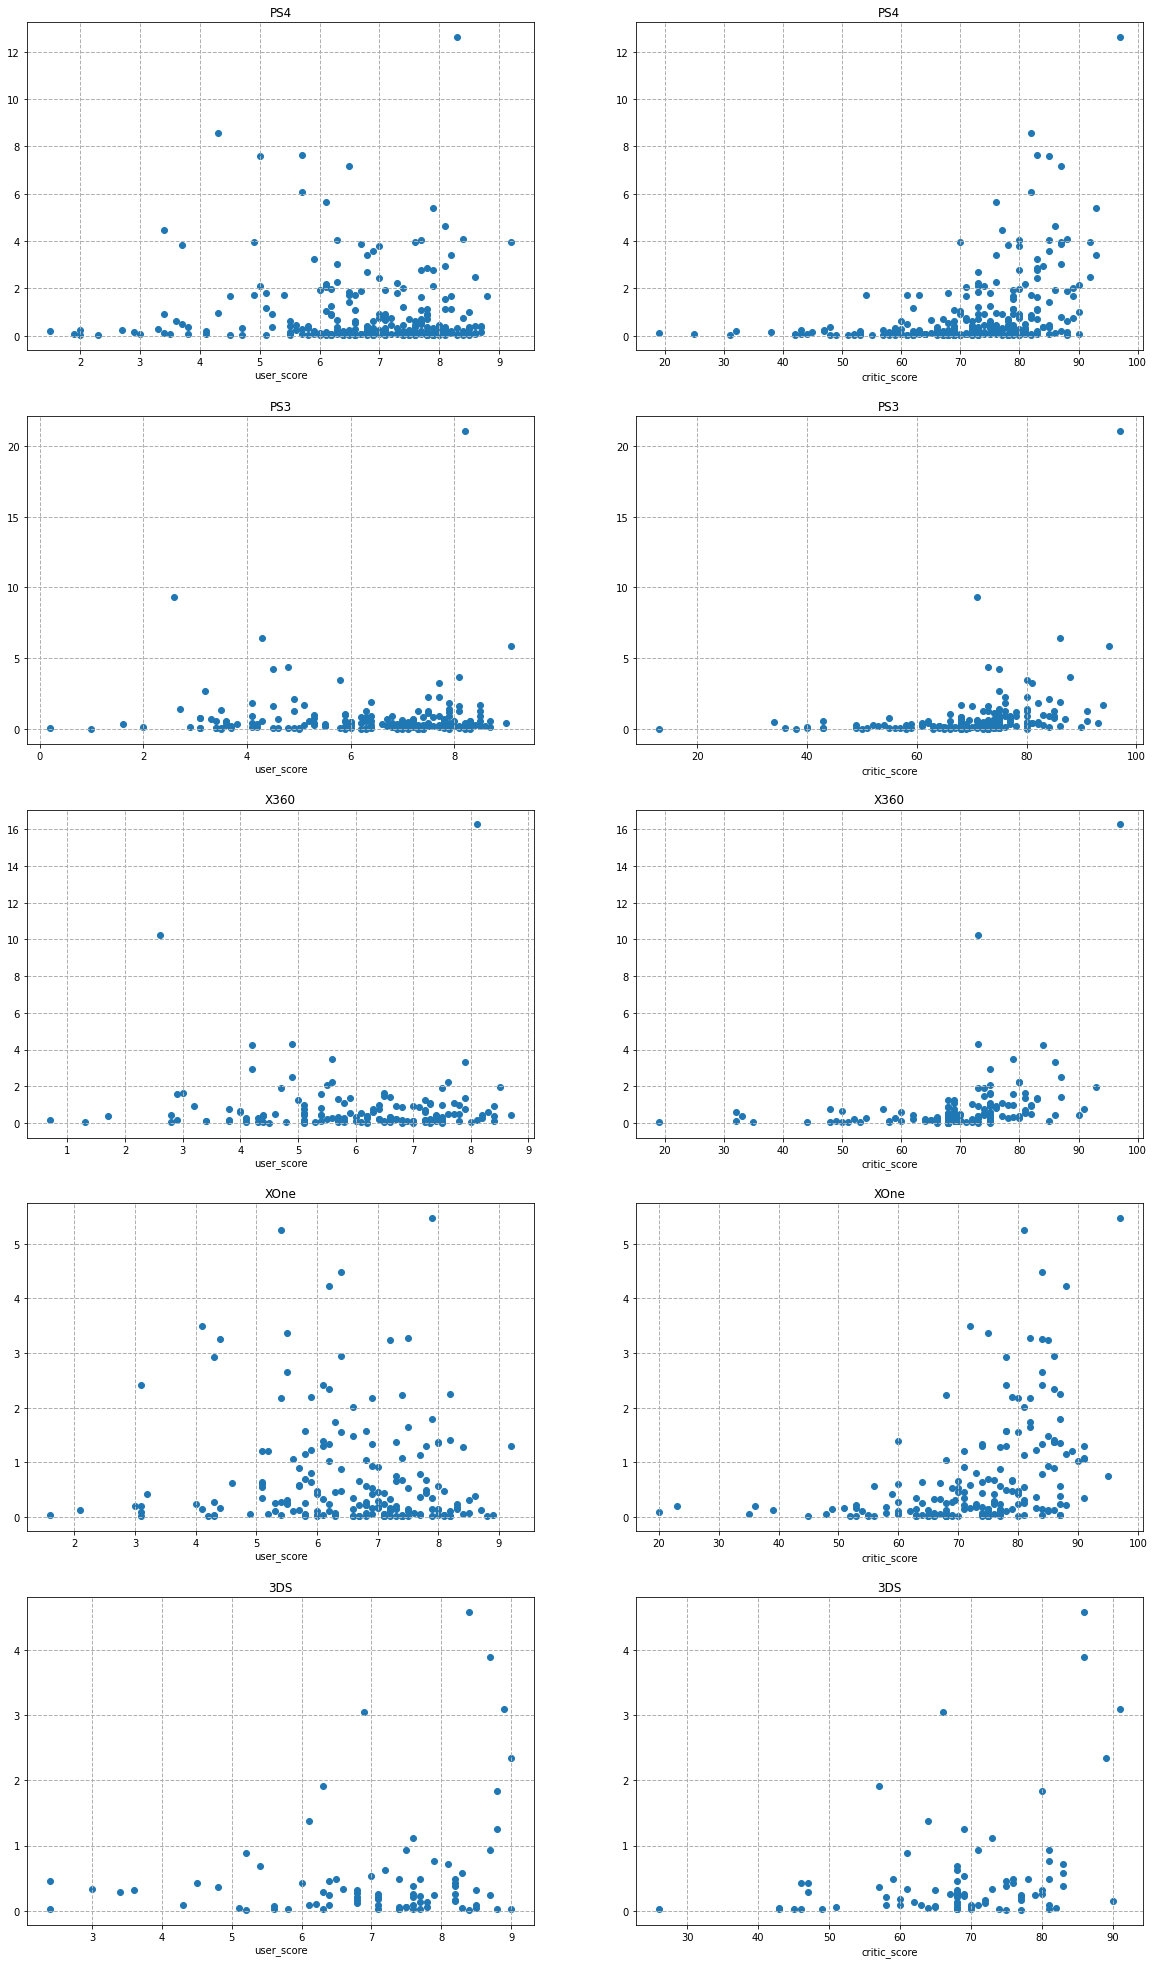

In [68]:
# Строим диаграмму рассеяния для оценок и продаж

fig, axes = plt.subplots(nrows=5, ncols=2)

fig.set_figwidth(20)  
fig.set_figheight(35)

axes[0, 0].scatter(x=df[df['platform'] == 'PS4']['user_score'], y=df[df['platform'] == 'PS4']['total_sales'])
axes[0, 1].scatter(x=df[df['platform'] == 'PS4']['critic_score'], y=df[df['platform'] == 'PS4']['total_sales'])

axes[1, 0].scatter(x=df[df['platform'] == 'PS3']['user_score'], y=df[df['platform'] == 'PS3']['total_sales'])
axes[1, 1].scatter(x=df[df['platform'] == 'PS3']['critic_score'], y=df[df['platform'] == 'PS3']['total_sales'])

axes[2, 0].scatter(x=df[df['platform'] == 'X360']['user_score'], y=df[df['platform'] == 'X360']['total_sales'])
axes[2, 1].scatter(x=df[df['platform'] == 'X360']['critic_score'], y=df[df['platform'] == 'X360']['total_sales'])

axes[3, 0].scatter(x=df[df['platform'] == 'XOne']['user_score'], y=df[df['platform'] == 'XOne']['total_sales'])
axes[3, 1].scatter(x=df[df['platform'] == 'XOne']['critic_score'], y=df[df['platform'] == 'XOne']['total_sales'])

axes[4, 0].scatter(x=df[df['platform'] == '3DS']['user_score'], y=df[df['platform'] == '3DS']['total_sales'])
axes[4, 1].scatter(x=df[df['platform'] == '3DS']['critic_score'], y=df[df['platform'] == '3DS']['total_sales'])


axes[0, 0].set(title='PS4', xlabel='user_score')
axes[0, 1].set(title='PS4', xlabel='critic_score')
axes[1, 0].set(title='PS3', xlabel='user_score')
axes[1, 1].set(title='PS3', xlabel='critic_score')
axes[2, 0].set(title='X360', xlabel='user_score')
axes[2, 1].set(title='X360', xlabel='critic_score')
axes[3, 0].set(title='XOne', xlabel='user_score')
axes[3, 1].set(title='XOne', xlabel='critic_score')
axes[4, 0].set(title='3DS', xlabel='user_score')
axes[4, 1].set(title='3DS', xlabel='critic_score')

for ax in axes.flat:
    ax.grid(linewidth = 1,   
        linestyle = '--')

plt.show()

In [69]:
for i in platforms_top5:
    
    r_user = df[df['platform'] == i]['user_score'].corr(df[df['platform'] == i]['total_sales']).round(3)
    r_critic = df[df['platform'] == i]['critic_score'].corr(df[df['platform'] == i]['total_sales']).round(3)
    
    print(f'Коэфф. корр. между оценками пользователей и общими продажами для платформы {i} составляет: {r_user}')
    print(f'Коэфф. корр. между оценками критиков и общими продажами для платформы {i} составляет: {r_critic}\n')

Коэфф. корр. между оценками пользователей и общими продажами для платформы PS4 составляет: -0.034
Коэфф. корр. между оценками критиков и общими продажами для платформы PS4 составляет: 0.408

Коэфф. корр. между оценками пользователей и общими продажами для платформы PS3 составляет: 0.001
Коэфф. корр. между оценками критиков и общими продажами для платформы PS3 составляет: 0.323

Коэфф. корр. между оценками пользователей и общими продажами для платформы XOne составляет: -0.078
Коэфф. корр. между оценками критиков и общими продажами для платформы XOne составляет: 0.417

Коэфф. корр. между оценками пользователей и общими продажами для платформы 3DS составляет: 0.23
Коэфф. корр. между оценками критиков и общими продажами для платформы 3DS составляет: 0.343

Коэфф. корр. между оценками пользователей и общими продажами для платформы X360 составляет: -0.012
Коэфф. корр. между оценками критиков и общими продажами для платформы X360 составляет: 0.326



Корреляция продаж с пользовательскими оценками оказалась очень слабой и, преимущественно, отрицательной (за искл. платформ PS3 и 3DS). Корреляция продаж с оценками критиков положительна для всех платформ, и выше, однако, также весьма слабая (максимальное значение коэфф. не превышает 0.5).

* Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

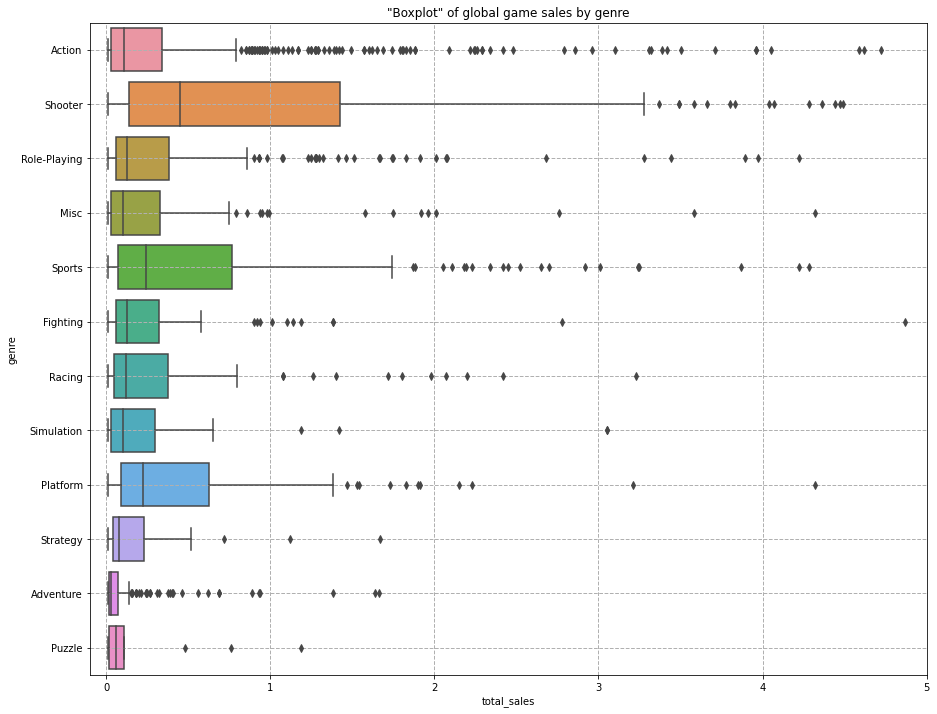

In [70]:
# Строим "ящик с усами" по глобальным продажам игр в разбивке по жанрам

fig, ax = plt.subplots()

fig.set_figwidth(15)  
fig.set_figheight(12) 

sns.boxplot(y='genre', x='total_sales', data=df, ax=ax, orient="h")

ax.grid(linewidth=1,   
        linestyle='--')
ax.set(title='"Boxplot" of global game sales by genre')

plt.xlim(-0.1, 5)
plt.show()

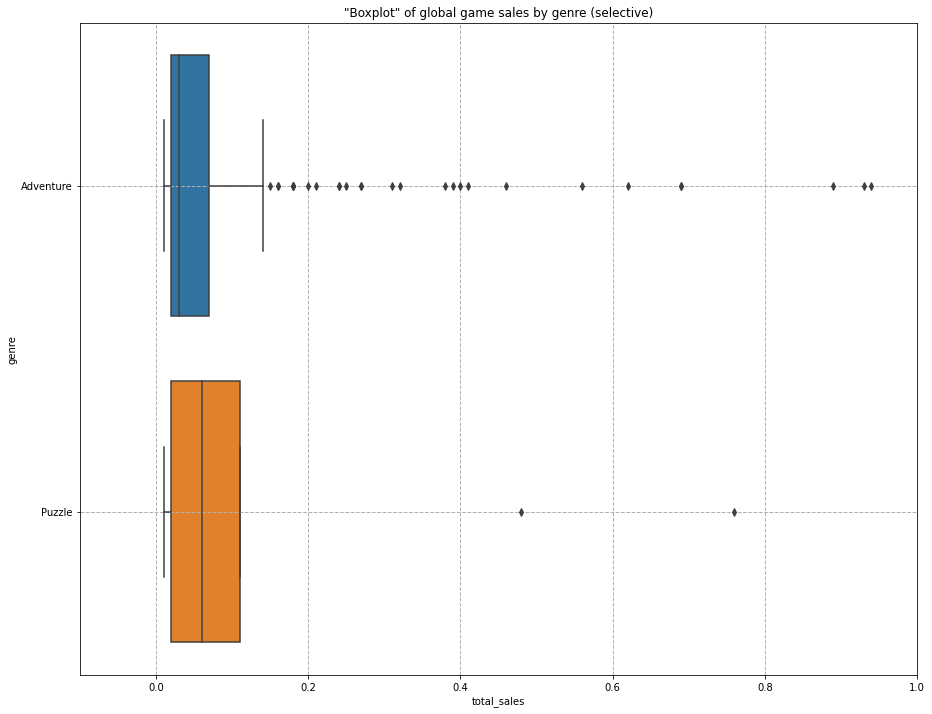

In [71]:
# Строим выборочный "ящик с усами" по глобальным продажам игр в разбивке по жанрам 
# только для жанров: "Adventure", "Puzzle"

fig, ax = plt.subplots()

fig.set_figwidth(15)  
fig.set_figheight(12) 

sns.boxplot(y='genre', x='total_sales', data=df[df['genre'].isin(['Adventure', 'Puzzle'])], ax=ax, orient="h")

ax.grid(linewidth=1,   
        linestyle='--')
ax.set(title='"Boxplot" of global game sales by genre (selective)')

plt.xlim(-0.1, 1)
plt.show()

Самым прибыльным жанром является жанр `Shooter`, за ним можно выделить жанры `Platform` и `Sports`. Самые низкие продажи у жанров `Puzzle` и `Adventure`.

#### Вывод:

В процессе исследования установлен актуальный период, годы с 2013 по 2016, для дальнейшего анализа. На данный момент наиболее прибыльными выбраны платформы `PS4` и `XOne`, а среди жанров предпочтительными являются жанры: `Shooter`, и, в меньшей степени, `Platform` и `Sports`, тогда как жанры `Puzzle` и `Adventure` выглядят совсем беспреспективными. Также, обнаружена довольно слабая положительная корреляция между оценками критиков и продажами, с оценками пользователей продажи практически не коррелируют.

### Составление портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):

* Самые популярные платформы (топ-5). Опишем различия в долях продаж.

In [72]:
# Рассмотрим распределение суммарных продаж по платформам в разрезе регионов

regions = ['na_sales', 'eu_sales', 'jp_sales']

sales_regions = df.groupby('platform')[regions].agg(['sum']).droplevel(1, axis=1)
sales_regions.reset_index(inplace=True)

sales_regions

,platform,na_sales,eu_sales,jp_sales
0,3DS,38.20,30.96,67.81
1,DS,0.57,0.85,0.00
2,PC,11.11,25.36,0.00
3,PS3,63.50,67.81,23.35
4,PS4,108.74,141.09,15.96
5,PSP,0.00,0.17,3.29
6,PSV,5.04,6.10,18.59
7,Wii,6.56,5.93,0.05
8,WiiU,29.21,19.85,10.88
9,X360,81.66,42.52,0.51


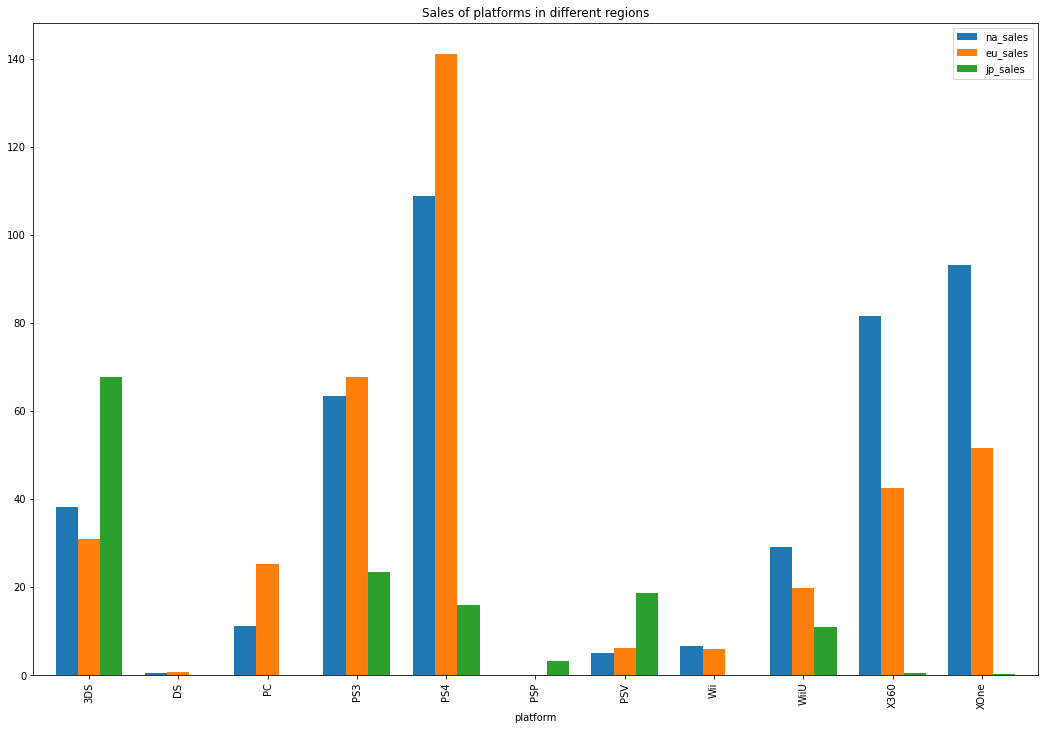

In [73]:
# Строим график суммарных продаж по платформам в разных регионах

fig, ax = plt.subplots()

fig.set_figwidth(18)  
fig.set_figheight(12) 

sales_regions.plot(x='platform', y=regions, kind='bar', ax=ax, width=0.75)

ax.set(title='Sales of platforms in different regions')

plt.show()

Для оценки различия в долях продаж построим круговые диаграммы для пяти популярных платформ в каждом регионе:

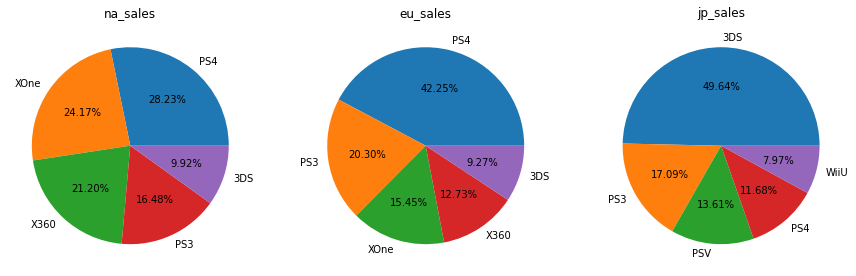

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.set_figwidth(15)  
fig.set_figheight(9)

for i, region in enumerate(regions):
    
    top5_platforms_reg = df.groupby('platform')[region].agg(['sum']).sort_values(by='sum', ascending=False)[:5]
    top5_platforms_reg.reset_index(inplace=True)
    
    values = top5_platforms_reg['sum']
    labels = top5_platforms_reg['platform']
    
    axes[i].pie(values, labels=labels, autopct='%1.2f%%')
    axes[i].set(title=region)
    
plt.show()

С учётом актуального периода с 2013 по 2016 год, имеем следующую картину: в Северной Америке по продажам выделяется тройка платформ `PS4`, `X360` и `XOne`; в Европе лидирует платформа `PS4`, чуть меньше продаж приходитмя на платформу `PS3`. В Японии самой популярной является платформа `3DS` (половина всех продаж приходится на эту платформу).

* Самые популярные жанры (топ-5). Поясним разницу.

По аналогии с предыдущим пунктом исследуем популярные жанры в разных регионах:

In [75]:
# Рассмотрим распределение суммарных продаж по жанрам в разрезе регионов

regions = ['na_sales', 'eu_sales', 'jp_sales']

sales_regions = df.groupby('genre')[regions].agg(['sum']).droplevel(1, axis=1)
sales_regions.reset_index(inplace=True)

sales_regions

,genre,na_sales,eu_sales,jp_sales
0,Action,126.05,118.13,40.49
1,Adventure,7.14,8.25,5.82
2,Fighting,15.55,8.55,7.65
3,Misc,27.49,20.04,9.20
4,Platform,18.14,15.58,4.79
5,Puzzle,0.83,1.00,1.18
6,Racing,12.96,20.19,2.30
7,Role-Playing,46.40,36.97,51.04
8,Shooter,109.74,87.86,6.61
9,Simulation,4.86,10.92,4.52


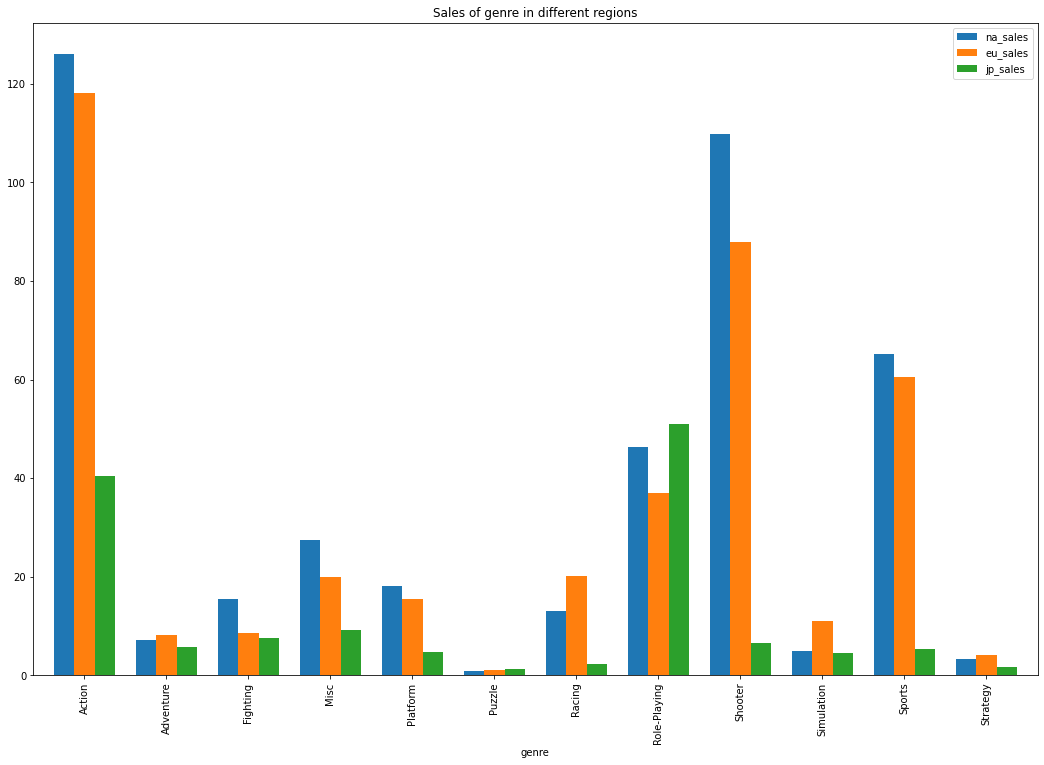

In [76]:
# Строим график суммарных продаж по жанрам в разных регионах

fig, ax = plt.subplots()

fig.set_figwidth(18)  
fig.set_figheight(12) 

sales_regions.plot(x='genre', y=regions, kind='bar', ax=ax, width=0.75)

ax.set(title='Sales of genre in different regions')

plt.show()

Для оценки различия в долях продаж построим круговые диаграммы для пяти популярных жанров в каждом регионе:

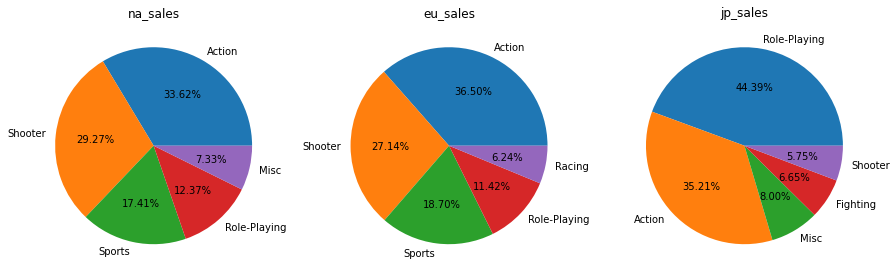

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.set_figwidth(15)  
fig.set_figheight(9)

for i, region in enumerate(regions):
    
    top5_genre_reg = df.groupby('genre')[region].agg(['sum']).sort_values(by='sum', ascending=False)[:5]
    top5_genre_reg.reset_index(inplace=True)
    
    values = top5_genre_reg['sum']
    labels = top5_genre_reg['genre']
    
    axes[i].pie(values, labels=labels, autopct='%1.2f%%')
    axes[i].set(title=region)
    
plt.show()

С учётом актуального периода с 2013 по 2016 год, имеем следующую картину: в Северной Америке по продажам выделяется жанр `Action`, чуть менее популярен жанр `Shooter`; в Европе картина практически аналогична Северной Америке. В Японии самым популярным жанром является `Role-Playing` (около 45% всех продаж приходится на игры этого жанра) и немного менее популярен жанр `Action` (около 35% продаж).

* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [78]:
rating_reg = df.pivot_table(index='rating', values=regions, aggfunc=['count', 'sum', 'mean'])
rating_reg

count                        sum                        mean  \
        eu_sales jp_sales na_sales eu_sales jp_sales na_sales  eu_sales   
rating                                                                    
E            355      355      355    84.40    19.08    80.16  0.237746   
E10+         252      252      252    42.69     5.89    54.24  0.169405   
M            369      369      369   145.32    14.11   165.21  0.393821   
T            333      333      333    41.95    20.59    49.79  0.125976   
unknown      924      924      924    77.87    81.11    88.31  0.084275   

                             
         jp_sales  na_sales  
rating                       
E        0.053746  0.225803  
E10+     0.023373  0.215238  
M        0.038238  0.447724  
T        0.061832  0.149520  
unknown  0.087781  0.095574

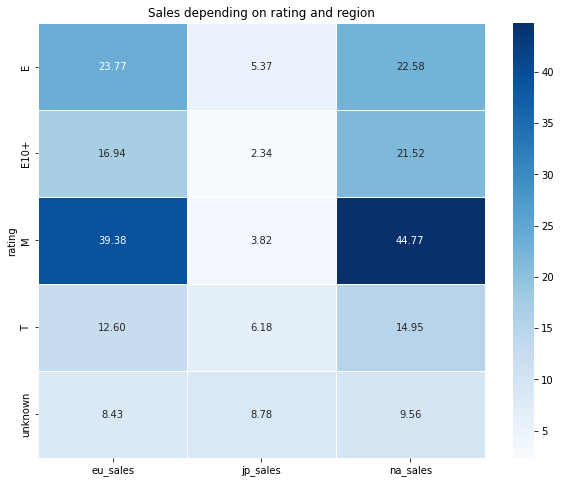

In [79]:
# Строим тепловую карту для оценки продаж в зависимости от рейтинга и региона продажи

fig, ax = plt.subplots()

# задаём ширину и высоту 
fig.set_figwidth(10)  
fig.set_figheight(8) 

data = rating_reg['mean'] * 100

sns.heatmap(data, ax=ax, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

# добавляем название графика
ax.set(title='Sales depending on rating and region')

plt.show()

Для актуального периода в Северной Америке и Европе наблюдается схожая картина влияния рейтинга на объём продаж: преобладают продажи игр с рейтингами `M` и, в меньшей степени, `E`. В Японии наибольший процент продаж у игр с неизвестным рейтингом `unknown`, примерно одинаково распределены продажи для игр с рейтингами `T` и `E`, и, в целом, наблюдается очень низкий процент продаж по всем рейтингам.

Для категории рейтинга `unknown` характерно примерно одинаковое распределение процента продаж по регионам, причём, процент продаж довольно мал (тогда как количество таких игр довольно велико и одинаково).

#### Вывод:
Портреты пользователей из Северной Америки и Европы в чём-то похожи: в Северной Америке и Европе по продажам лидирует платформа `PS4`, выделяются жанры `Action` и `Shooter`, преобладают игры с рейтингом `E`. В Японии самой популярной является платформа `3DS` (половина всех продаж приходится на эту платформу), а среди жанров выделяется `Role-Playing` (около 45% всех продаж приходится на игры этого жанра), процент продаж по рейтингам совсем низкий, незначительно преобладают игры с неизвестным рейтингом `unknown`, и в меньшей степени с рейтингами `T` и `E`.

### Проверка гипотез

* Проверим гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [80]:
# Найдём по имеющимся данным средние пользов. рейтинги для игр на платформах XOne и PC 

df.query('platform in ["XOne", "PC"]').groupby('platform')['user_score'].agg(['count', 'mean'])

,count,mean
platform,,
PC,156,6.276923
XOne,186,6.540860


Видно, что средние пользовательские рейтинги данных платформ практически не отличаются, сформулируем нулевую (H0) и альтернативную (H1) гипотезы:

- Н0: средние пользовательские рейтинги платформ Xbox One и PC равны
- H1: средние пользовательские рейтинги платформ Xbox One и PC не равны

Проверим двустороннюю гипотезу о равенстве средних двух генеральных совокупностей. Используем метод `scipy.stats.ttest_ind` (параметр `equal_var` оставим по умолчанию). Пороговое значение `alpha` установим равным 0.05:  

In [81]:
sample_xone = df[df['platform'] == 'XOne']['user_score'].dropna()
sample_pc = df[df['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

print('p-значение:', st.ttest_ind(sample_xone, sample_pc).pvalue.round(2))

if st.ttest_ind(sample_xone, sample_pc).pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.12
Не получилось отвергнуть нулевую гипотезу


Таким образом, нет оснований делать вывод о значимом различии между пользовательскими рейтингами платформ XOne и PS.

* Проверим гипотезу: средние пользовательские рейтинги жанров `Action` и `Sports` разные

In [82]:
# Найдём по имеющимся данным средние пользов. рейтинги для игр в жанрах Action и Sports 

df.query('genre in ["Action", "Sports"]').groupby('genre')['user_score'].agg(['count', 'mean'])

,count,mean
genre,,
Action,393,6.843257
Sports,162,5.264815


Видно, что средние пользовательские рейтинги игр данных жанров отличаются, сформулируем нулевую (H0) и альтернативную (H1) гипотезы:

- Н0: средние пользовательские рейтинги игр в жанрах Action и Sports равны
- H1: средние пользовательские рейтинги игр в жанрах Action и Sports не равны

Проверим двустороннюю гипотезу о равенстве средних двух генеральных совокупностей. Используем метод `scipy.stats.ttest_ind` (параметр `equal_var` положим равным False). Пороговое значение `alpha` установим равным 0.001:  

In [83]:
sample_action = df[df['genre'] == 'Action']['user_score'].dropna()
sample_sports = df[df['genre'] == 'Sports']['user_score'].dropna()

alpha = 0.001 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

print('p-значение:', st.ttest_ind(sample_action, sample_sports, equal_var=False).pvalue)

if st.ttest_ind(sample_action, sample_sports, equal_var=False).pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.5593568356495487e-20
Отвергаем нулевую гипотезу


Таким образом, есть основания сделать вывод о том, что различия между пользовательскими рейтингами игр в жанрах `Action` и `Sports` статистически значимые.

### Общий вывод

Проведён первичный анализ данных. Там, где это было возможно, устранены пропуски и обработаны нетипичные(аномальные) значения ряда признаков. Необработанные пропуски в признаке `rating` заполнены значением `unknown`. 

Определён актуальный период с 2013г., участвующий в основном анализе данных. Потенциально прибыльными выглядят платформы `PS4` и `XOne`, для них наблюдается рост числа продаж с 2013 года, тогда как для остальных, достаточно хорошо продающихся платформ, в актуальном периоде наблюдается снижение продаж.

Отмечено наличие очень слабой корреляции продаж с пользовательскими оценками и, преимущественно, отрицательной. Корреляция продаж с оценками критиков положительна для всех платформ, но также весьма слабая (максимальное значение коэфф. не превышает 0.5).

Установлена схожесть портретов пользователей из Северной Америки и Европы: лидирующие позиции по продажам игр на платформе `PS4`, с преобладанием игр в жанрах `Action` и `Shooter`. Для Японских пользователей обнаружены иные показатели, так, самой популярной является платформа `3DS`, а среди жанров выделяется `Role-Playing`.

Достаточно существенное и равномерное (относительно регионов) количество игр с пропусками в рейтинге (значение `unknown`) требует необходимости перепроверки данных, или уточнения данных в данном признаке (возможно рейтинг был неправильно заполнен, или этот рейтинг не из системы ESRB...)